Importamos Librerías 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn import metrics

Vamos a ingestar los archivos en un dataframe con pandas, asi podemos revisarlo y hacer las tranformaciones necesarias antes de armar el modelo

In [4]:
df_train= pd.read_csv('./datasets/hospitalizaciones_train.csv')
df_test= pd.read_csv('./datasets/hospitalizaciones_test.csv')

EDA
Todos los cambios que apliquemos sera para ambos dataframe

In [5]:
#Vemos los primeros registros y analizamos columnas y datos
df_train.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [6]:
#Vemos si hay presencia de nulos y el tipo de dato de cada columna
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

In [7]:
#Buscamos duplicados
df_train.duplicated().sum()

0

In [8]:
#Agregamos una columna en la cual si la estadia es mayor a 8 coloca 1, de lo contrario 0
df_train["Long_stay"] = np.where(df_train["Stay (in days)"]>8,1,0)

In [9]:
#Vamos a transformar cada columna en categorica agregandole _new para distinguirlas
for columna in df_train.columns:
    df_train[columna] = pd.Categorical(df_train[columna])
    df_train[f'{columna}_new'] = df_train[columna].cat.codes

In [10]:
#Vamos a transformar cada columna en categorica agregandole _new para distinguirlas en el df test
for columna in df_test.columns:
    df_test[columna] = pd.Categorical(df_test[columna])
    df_test[f'{columna}_new'] = df_test[columna].cat.codes

In [11]:
#Eliminamos todas las columnas viejas sin el _new
df_train.drop(['Available Extra Rooms in Hospital', 'Department', 'Ward_Facility_Code',
       'doctor_name', 'staff_available', 'patientid', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Visitors with Patient', 'Insurance', 'Admission_Deposit',
       'Stay (in days)', 'Long_stay'], axis=1, inplace=True)

In [12]:
#Eliminamos todas las columnas viejas sin el _new en el df test
df_test.drop(['Available Extra Rooms in Hospital', 'Department', 'Ward_Facility_Code',
       'doctor_name', 'staff_available', 'patientid', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Visitors with Patient', 'Insurance', 'Admission_Deposit'], axis=1, inplace=True)

In [13]:
#Borramos columnas que no nos van a servir para correlacion
df_train = df_train.drop(columns=['Ward_Facility_Code_new', 'doctor_name_new', 'patientid_new', 'Visitors with Patient_new', 'Admission_Deposit_new', 'Stay (in days)_new'])

In [14]:
#Borramos columnas que no nos van a servir para correlacion en el df test
df_test = df_test.drop(columns=['Ward_Facility_Code_new', 'doctor_name_new', 'patientid_new', 'Visitors with Patient_new', 'Admission_Deposit_new'])

In [15]:
#Observamos como quedo el dataframe
df_train.head()

,Available Extra Rooms in Hospital_new,Department_new,staff_available_new,Age_new,gender_new,Type of Admission_new,Severity of Illness_new,health_conditions_new,Insurance_new,Long_stay_new
0,4,2,0,4,0,1,0,1,1,0
1,4,2,2,3,0,1,1,2,0,1
2,2,2,8,2,0,1,0,1,1,0
3,4,2,7,3,0,2,2,4,0,0
4,2,1,10,7,1,1,2,1,0,1


In [16]:
#Observamos las correlaciones de los datos
df_train.corr()

,Available Extra Rooms in Hospital_new,Department_new,staff_available_new,Age_new,gender_new,Type of Admission_new,Severity of Illness_new,health_conditions_new,Insurance_new,Long_stay_new
Available Extra Rooms in Hospital_new,1.000000,-0.017947,-0.002804,-0.036023,-0.047962,0.007834,0.028238,0.001559,0.002807,0.043327
Department_new,-0.017947,1.000000,0.016304,0.013096,0.016474,-0.037395,0.014698,-0.000344,-0.000714,-0.173021
staff_available_new,-0.002804,0.016304,1.000000,0.001818,0.003960,-0.002255,0.002759,-0.001500,0.001245,0.002883
Age_new,-0.036023,0.013096,0.001818,1.000000,0.497530,0.005304,0.023350,0.037140,-0.002472,0.229657
gender_new,-0.047962,0.016474,0.003960,0.497530,1.000000,0.031566,0.029147,-0.000242,0.001657,0.193878
Type of Admission_new,0.007834,-0.037395,-0.002255,0.005304,0.031566,1.000000,-0.070795,0.001768,-0.002062,0.006233
Severity of Illness_new,0.028238,0.014698,0.002759,0.023350,0.029147,-0.070795,1.000000,0.214291,0.001924,0.017030
health_conditions_new,0.001559,-0.000344,-0.001500,0.037140,-0.000242,0.001768,0.214291,1.000000,0.008702,-0.002568
Insurance_new,0.002807,-0.000714,0.001245,-0.002472,0.001657,-0.002062,0.001924,0.008702,1.000000,-0.001063
Long_stay_new,0.043327,-0.173021,0.002883,0.229657,0.193878,0.006233,0.017030,-0.002568,-0.001063,1.000000


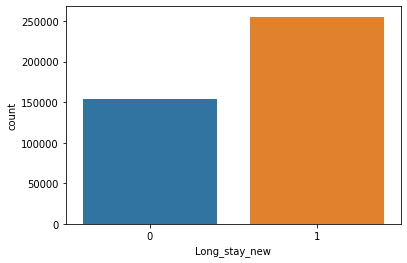

In [17]:
#Graficamos la estadia en numeros
sns.countplot(x = 'Long_stay_new', data = df_train)
plt.show()

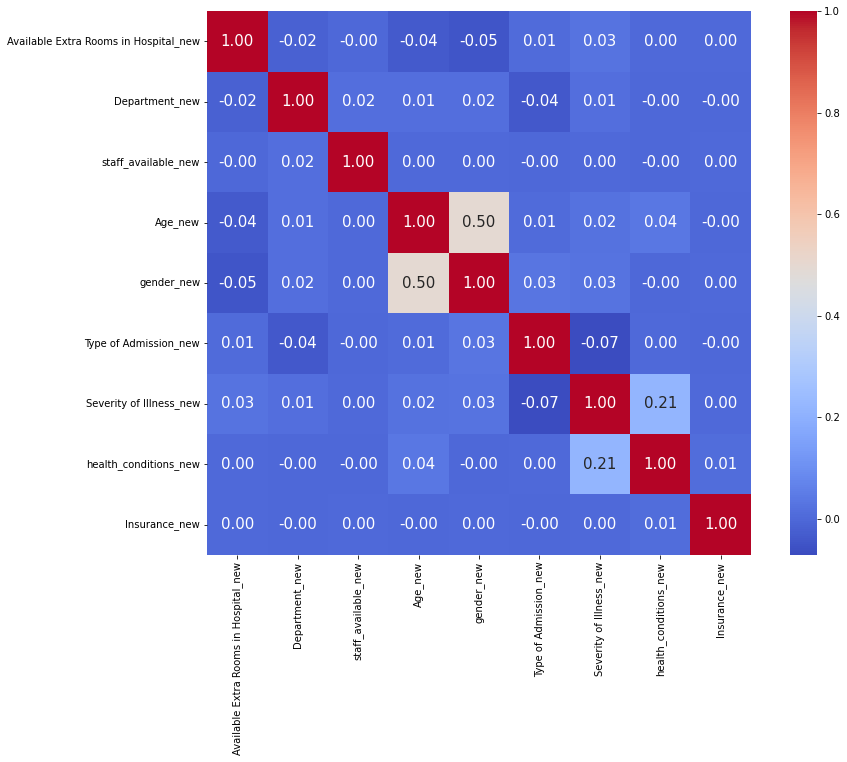

In [18]:
#Hacemos un mapa de calor
corr = df_train.drop(columns = ['Long_stay_new']).corr(method='pearson')
plt.figure(figsize=(14,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_train.drop(columns = ['Long_stay_new']).columns, 
           yticklabels= df_train.drop(columns = ['Long_stay_new']).columns,
           cmap= 'coolwarm')

plt.show()

In [19]:
#Vemos las correlaciones ordenandolas de forma descendente
corr = df_train.corr()
corr[['Long_stay_new']].sort_values(by = 'Long_stay_new',ascending = False)

,Long_stay_new
Long_stay_new,1.000000
Age_new,0.229657
gender_new,0.193878
Available Extra Rooms in Hospital_new,0.043327
Severity of Illness_new,0.017030
Type of Admission_new,0.006233
staff_available_new,0.002883
Insurance_new,-0.001063
health_conditions_new,-0.002568
Department_new,-0.173021


In [20]:
#Establecemos variables x e y
x= df_train.drop(['Long_stay_new'], axis= 1)
y= df_train['Long_stay_new']

In [24]:
# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

Entrenamiento de Random Forest:
Hiperparametros por defecto

In [34]:
model = RandomForestClassifier()

In [35]:
#Entrenamos el modelo 
model.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
#Hacemos las predicciones con los datos de testeo 
prediction = model.predict(X_test)

In [37]:
#Matriz de confusión
matriz = confusion_matrix(y_test,prediction)
print("Matriz de confusión:")
print(matriz)

Matriz de confusión:
[[18485 20329]
 [12089 51597]]


In [38]:
#Eeporte de clasificación (recall y accuracy)
reporte = classification_report(y_test, prediction)
print("Reporte de Clasificación:")
print(reporte)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.60      0.48      0.53     38814
           1       0.72      0.81      0.76     63686

    accuracy                           0.68    102500
   macro avg       0.66      0.64      0.65    102500
weighted avg       0.67      0.68      0.67    102500



In [39]:
#Imprimimos las métricas 
print("accuracy: ", metrics.accuracy_score(y_test, prediction))
print("Recall: ", metrics.recall_score(y_test, prediction))

accuracy:  0.6837268292682926
Recall:  0.8101780611123324


Predecimos con nuestro modelo la estadía de los pacientes

In [40]:
#Entrenamos
modelo_predict = RandomForestClassifier()
modelo_predict.fit(x,y)

RandomForestClassifier()

In [41]:
#Obtener nuestra columna 'pred' con las predicciones
predicciones = pd.DataFrame()
predicciones['pred'] = modelo_predict.predict(df_test)

In [42]:
predicciones

,pred
0,1
1,1
2,1
3,1
4,1
...,...
89995,0
89996,1
89997,1
89998,1


In [108]:
#Guardamos la columna en un archivo .csv
predicciones.to_csv(path_or_buf='./Jucepos.csv' , index=False)